In [185]:
import os
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import pickle
import tensorflow as tf
from matplotlib.image import imread
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow import keras
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, Lambda
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
import keras_tuner as kt
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop = stopwords.words('english')
tokenizer = Tokenizer(num_words = 8000, filters = '!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")

print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Tensorflow version: 2.8.0
Keras Version: 2.8.0
GPU is available


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass


In [4]:
data_dev = []
data_test = []
data_train = []
file_name_dev = "audioDataDev.pickle"
file_name_test = "audioDataTest.pickle"
file_name_train = "audioDataTrain.pickle"

with (open(file_name_dev, "rb")) as f:
    while True:
        try:
            data_dev.append(pickle.load(f))
        except EOFError:
            break
f.close()

with (open(file_name_test, "rb")) as f:
    while True:
        try:
            data_test.append(pickle.load(f))
        except EOFError:
            break
f.close()

with (open(file_name_train, "rb")) as f:
    while True:
        try:
            data_train.append(pickle.load(f))
        except EOFError:
            break
f.close()

In [4]:
data_test[1][4]

'0    Hi expo\nName: 4, dtype: object'

In [5]:
X_dev = []
X_dev_text = []
y_dev = []
X_train = []
X_train_text = []
y_train = []
X_test = []
X_test_text = []
y_test = []

for i in range(len(data_dev)-1):
    X_dev.append(data_dev[i+1][3])
for i in range(len(data_dev)-1):
    X_dev_text.append(data_dev[i+1][4])
for i in range(len(data_dev)-1):
    y_dev.append(data_dev[i+1][6:12])
    
for i in range(len(data_test)-1):
    X_test.append(data_test[i+1][3])
for i in range(len(data_test)-1):
    X_test_text.append(data_test[i+1][4])
for i in range(len(data_test)-1):
    y_test.append(data_test[i+1][6:12])
    
for i in range(len(data_train)-1):
    X_train.append(data_train[i+1][3])
for i in range(len(data_train)-1):
    X_train_text.append(data_train[i+1][4])
for i in range(len(data_train)-1):
    y_train.append(data_train[i+1][6:12])

X_dev = np.array(X_dev)
X_dev_text = np.array(X_dev_text)
y_dev = np.where(np.array(y_dev)> 0.5, 1, 0)
X_test = np.array(X_test)
X_test_text = np.array(X_test_text)
y_test = np.where(np.array(y_test) > 0.5, 1, 0)
X_train = np.array(X_train)
X_train_text = np.array(X_train_text)
y_train = np.where(np.array(y_train) > 0.5, 1, 0)

4662

In [6]:
def sent(X, y):
    data = []
    for i in range(1, len(X)):
        #add text
        temp = X[i].split('\n')
        text_obj = temp[0][6:]

        row = [text_obj, np.array(y[i])]
        data.append(row)

    df = pd.DataFrame(data, columns = ['text', 'sentiment'])
    return df

def remove_punctuation(text):
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def remove_stopwords(text):
    sw = stopwords.words('english')
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    return " ".join(text)

def sequences(dframe):
    tokenizer = Tokenizer(num_words = 8000, filters = '!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
    tokenizer.fit_on_texts(dframe['text'])
    X = tokenizer.texts_to_sequences(dframe['text'].values)
    y = dframe['sentiment'].values
    return X,y


In [7]:
dev_df = sent(X_dev_text, y_dev)
dev_df['text'] = dev_df['text'].apply(remove_punctuation).apply(remove_stopwords)
dev = sequences(dev_df)

test_df = sent(X_test_text, y_test)
test_df['text'] = test_df['text'].apply(remove_punctuation).apply(remove_stopwords)
test = sequences(test_df)

train_df = sent(X_train_text, y_train)
train_df['text'] = train_df['text'].apply(remove_punctuation).apply(remove_stopwords)
train = sequences(train_df)

In [8]:
X_dev_text = pad_sequences(dev[0])
y_dev_text = pad_sequences(dev[1])
X_test_text = pad_sequences(test[0])
y_test_text = pad_sequences(test[1])
X_train_text = pad_sequences(train[0])
y_train_text = pad_sequences(train[1])

In [9]:
X_train_text = X_train_text.reshape(X_train_text.shape[0], 1, X_train_text.shape[1])
X_test_text = X_test_text.reshape(X_test_text.shape[0], 1, X_test_text.shape[1])
X_dev_text = X_dev_text.reshape(X_dev_text.shape[0], 1, X_dev_text.shape[1])

array([[  0,   0,   0,   0,   0,   0, 652,   3, 453]])

In [ ]:
# get the model
def get_model_cnn():
    model = Sequential()
    model.add(Conv1D(32, kernel_size=(2), activation='relu', input_shape=(128, 850)))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters=64, kernel_size=(5), activation='relu'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters=128, kernel_size=(5), activation="relu"))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(6, activation='sigmoid'))
    return model
 
# evaluate a model using repeated k-fold cross-validation
adam = Adam(0.0001)
model_cnn = get_model_cnn()
model_cnn.compile(optimizer=adam,loss='binary_crossentropy',metrics=['AUC','BinaryAccuracy'])

model_cnn.fit(X_train, y_train, epochs=30, validation_data=(X_dev, y_dev), batch_size=10)

In [254]:
yhat = model_cnn_hyper.predict(X_test)

In [258]:
print(yhat[2])
print(y_test[2])

[7.7098936e-02 1.2738496e-02 1.2649357e-02 3.0161923e-06 7.8164041e-03
 1.0486991e-07]
[0 1 1 0 1 0]


In [264]:
model_cnn_hyper.save('modelCNN_hyper')

INFO:tensorflow:Assets written to: modelCNN_hyper\assets


In [259]:
threshold = 7e-03
yhat = np.where(yhat > threshold, 1, 0)


[1 0 0 0 0 0]
[1 0 0 0 0 0]


In [261]:
results=[]
total = 0
similar = 0
for i in range(len(y_test)):
    for j in range(len(y_test[i])):
        if y_test[i][j] == yhat[i][j]:
            similar += 1
        total += 1
acc = similar/total

print('>%.3f' % acc)
results.append(acc)

>0.702


In [262]:
y_test_f = []
y_hat_f = []
for i in range(len(yhat[0])):
    y_temp_t = []
    y_temp_h = []
    for j in range(len(yhat)):
        y_temp_t.append(y_test[j][i])
        y_temp_h.append(yhat[j][i])
    y_test_f.append(y_temp_t)
    y_hat_f.append(y_temp_h)
        

In [21]:
emotion = ['Happy', 'Sad', 'Anger', 'Surprise', 'Disgust', 'Fear']


for n, ax in zip(range(len(emotion)), axs.ravel()):
    # add a new subplot iteratively
    conf_matrix = confusion_matrix(y_true=y_test_f[n], y_pred=y_hat_f[n])
    #
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    # chart formatting
    ax.set_title('${}$'.format(emotion[n]), fontsize=18)
    ax.set_xlabel('Predictions', fontsize=18)
    ax.set_ylabel('Actuals', fontsize=18)    

NameError: name 'axs' is not defined

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

range_vals = [i/100 for i in range(1, 100)]


precision = []
recall = []
accuracy = []
for i in range_vals:
    precision.append(precision_score(y_test_f[1], y_hat_f[1]))
    recall.append(recall_score(y_test_f[1], y_hat_f[1]))
    accuracy.append(accuracy_score(y_test_f[1], y_hat_f[1]))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (11, 7))
sns.lineplot(range_vals, precision)
sns.scatterplot(range_vals, precision)
sns.lineplot(range_vals, recall)
sns.scatterplot(range_vals, recall)
sns.lineplot(range_vals, accuracy)
sns.scatterplot(range_vals, accuracy)
plt.legend(['', '', 'Acc'])
plt.show()

In [38]:
#set up the LSTM model
#using the LSTM model with relu activation
def get_model_lstm():
    lstm = keras.Sequential()
    lstm.add(LSTM(32, input_shape = (1, X_train_text.shape[2]), activation='relu', return_sequences=False))
    lstm.add(Dense(6, activation='sigmoid'))
    return lstm

adam = Adam(0.0001)
model_lstm = get_model_lstm()
model_lstm.compile(loss='binary_crossentropy',metrics='BinaryAccuracy', optimizer=adam)

In [39]:
model_lstm.fit(X_train_text, y_train_text, epochs=30, batch_size=10, verbose=1, shuffle=False)

Epoch 1/30
1633/1633 [==============================] - 4s 2ms/step - loss: 22.7029 - binary_accuracy: 0.6571
Epoch 2/30
1633/1633 [==============================] - 3s 2ms/step - loss: 4.7605 - binary_accuracy: 0.7878
Epoch 3/30
1633/1633 [==============================] - 3s 2ms/step - loss: 1.9241 - binary_accuracy: 0.8308
Epoch 4/30
1633/1633 [==============================] - 3s 2ms/step - loss: 1.0471 - binary_accuracy: 0.8515
Epoch 5/30
1633/1633 [==============================] - 3s 2ms/step - loss: 0.7073 - binary_accuracy: 0.8622
Epoch 6/30
1633/1633 [==============================] - 3s 2ms/step - loss: 0.5817 - binary_accuracy: 0.8658
Epoch 7/30
1633/1633 [==============================] - 3s 2ms/step - loss: 0.4910 - binary_accuracy: 0.8679
Epoch 8/30
1633/1633 [==============================] - 3s 2ms/step - loss: 0.4518 - binary_accuracy: 0.8689
Epoch 9/30
1633/1633 [==============================] - 3s 2ms/step - loss: 0.4189 - binary_accuracy: 0.8695
Epoch 10/30
1633/1

In [163]:
y_pred= model_lstm.predict(X_test_text)

In [164]:
y_pred

array([[0.5265398 , 0.2795878 , 0.22269046, 0.10858017, 0.2002585 ,
        0.10222942],
       [0.5338979 , 0.27288342, 0.2378596 , 0.11229983, 0.20027038,
        0.10253209],
       [0.5412264 , 0.26460683, 0.23202917, 0.11731607, 0.20069277,
        0.09830052],
       ...,
       [0.5338979 , 0.27288342, 0.2378596 , 0.11229983, 0.20027038,
        0.10253209],
       [0.5338979 , 0.27288342, 0.2378596 , 0.11229983, 0.20027038,
        0.10253209],
       [0.5338979 , 0.27288342, 0.2378596 , 0.11229983, 0.20027038,
        0.10253209]], dtype=float32)

In [165]:
threshold = 0.41
y_pred = np.where(y_pred > threshold, 1, 0)
print(y_pred[1])
print(y_test_text[1])

[1 0 0 0 0 0]
[0 1 1 0 1 0]


In [166]:
results=[]
total = 0
similar = 0
for i in range(len(y_test_text)):
    for j in range(len(y_test_text[i])):
        if y_test_text[i][j] == y_pred[i][j]:
            similar += 1
        total += 1
acc = similar/total

print('>%.3f' % acc)
results.append(acc)

>0.785


In [167]:
y_test_f = []
y_hat_f = []
for i in range(len(y_pred[0])):
    y_temp_t = []
    y_temp_h = []
    for j in range(len(y_pred)):
        y_temp_t.append(y_test_text[j][i])
        y_temp_h.append(y_pred[j][i])
    y_test_f.append(y_temp_t)
    y_hat_f.append(y_temp_h)

In [ ]:
emotion = ['Happy', 'Sad', 'Anger', 'Surprise', 'Disgust', 'Fear']


for n, ax in zip(range(len(emotion)), axs.ravel()):
    # add a new subplot iteratively
    conf_matrix = confusion_matrix(y_true=y_test_f[n], y_pred=y_hat_f[n])
    #
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    # chart formatting
    ax.set_title('${}$'.format(emotion[n]), fontsize=18)
    ax.set_xlabel('Predictions', fontsize=18)
    ax.set_ylabel('Actuals', fontsize=18)    

In [237]:
def build_model_cnn(hp):
  initializer = tf.keras.initializers.Constant(value=0.5)
  model = keras.Sequential([
    keras.layers.Conv1D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=256, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [2,3,4]),
        kernel_initializer=initializer,
        input_shape=(128, 850),
        padding='same'
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling1D(
        pool_size=hp.Choice('conv_1_pool', values = [1,2,3])
    ),
    keras.layers.Dropout(
        hp.Choice('conv_1_drop',values=[0.25, 0.5])
    ),
    keras.layers.Conv1D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [2,3,4]),
        padding='same'
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling1D(
        pool_size=hp.Choice('conv_2_pool', values = [1,2,3])
    ),
    keras.layers.Dropout(
        hp.Choice('conv_2_drop',values=[0.25, 0.5])
    ),
    keras.layers.Conv1D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=256, step=16),
        kernel_size=hp.Choice('conv_3_kernel', values = [2,3,4]),
        input_shape=(128, 850),
        padding='same'
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling1D(
        pool_size=hp.Choice('conv_3_pool', values = [1,2,3])
    ),
    keras.layers.Dropout(
        hp.Choice('conv_3_drop',values=[0.25, 0.5])
    ),
    keras.layers.Conv1D(
        filters=hp.Int('conv_4_filter', min_value=32, max_value=256, step=16),
        kernel_size=hp.Choice('conv_4_kernel', values = [2,3,4]),
        input_shape=(128, 850),
        padding='same'
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling1D(
        pool_size=hp.Choice('conv_4_pool', values = [1,2,3])
    ),
    keras.layers.Dropout(
        hp.Choice('conv_4_drop',values=[0.25, 0.5])
    ),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_4_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(
        hp.Choice('final_drop',values=[0.25, 0.5])
    ),
    keras.layers.Dense(6, activation='sigmoid')
    ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[5e-4,3e-4,1e-4])),
              loss=['binary_crossentropy',
                    'binary_crossentropy',
                    'binary_crossentropy',
                    'binary_crossentropy',
                    'binary_crossentropy',
                    'binary_crossentropy'],
              loss_weights=[0.8945161035055789,
                         0.35372319379599587,
                         0.3364722639867057,
                         0.0800822980137691,
                         0.25496557727308694,
                         0.08024056342486349],
              metrics=['BinaryAccuracy'])
  
  return model



In [238]:
tuner_search=RandomSearch(build_model_cnn,objective=["val_accuracy", "val_loss"],max_trials=5,directory='output_cnn7',project_name="MOSEI CNN")

INFO:tensorflow:Reloading Oracle from existing project output_cnn7\MOSEI CNN\oracle.json


In [239]:
tuner_search.search(X_train, y_train,epochs=6,validation_data=(X_dev, y_dev))

Trial 5 Complete [00h 02m 15s]
multi_objective: 0.2812107503414154

Best multi_objective So Far: 0.2806006968021393
Total elapsed time: 00h 19m 51s
INFO:tensorflow:Oracle triggered exit


In [240]:
model_cnn_hyper=tuner_search.get_best_models(num_models=1)[0]
model_cnn_hyper.fit(X_train, y_train, epochs=20, validation_data=(X_dev, y_dev), batch_size=16)

Epoch 1/20
1021/1021 [==============================] - 58s 55ms/step - loss: 0.3042 - binary_accuracy: 0.8705 - val_loss: 0.2815 - val_binary_accuracy: 0.8821
Epoch 2/20
1021/1021 [==============================] - 55s 54ms/step - loss: 0.3034 - binary_accuracy: 0.8708 - val_loss: 0.2819 - val_binary_accuracy: 0.8832
Epoch 3/20
1021/1021 [==============================] - 55s 54ms/step - loss: 0.3011 - binary_accuracy: 0.8710 - val_loss: 0.2815 - val_binary_accuracy: 0.8830
Epoch 4/20
1021/1021 [==============================] - 56s 54ms/step - loss: 0.2986 - binary_accuracy: 0.8717 - val_loss: 0.2803 - val_binary_accuracy: 0.8834
Epoch 5/20
1021/1021 [==============================] - 56s 55ms/step - loss: 0.2990 - binary_accuracy: 0.8721 - val_loss: 0.2816 - val_binary_accuracy: 0.8825
Epoch 6/20
1021/1021 [==============================] - 56s 55ms/step - loss: 0.2982 - binary_accuracy: 0.8718 - val_loss: 0.2806 - val_binary_accuracy: 0.8836
Epoch 7/20
1021/1021 [==================

array([0.03761567, 0.03761567, 0.07104516, ..., 0.34360778, 0.03761567,
       0.07104516])

In [15]:
model_cnn_hyper.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 128, 224)          571424    
                                                                 
 batch_normalization (BatchN  (None, 128, 224)         896       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 64, 224)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 224)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 64, 48)            32304     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 48)           1

In [241]:
yhat = model_cnn_hyper.predict(X_test)

In [225]:
print(yhat[3])
print(y_train[3])
array = [0,0,0,0,0,0]
for i in range(len(y_train)):
    for j in range(len(y_train[1])):
        if y_train[i][j] == 1:
            array[j] += 1
        else:
            continue
    


[0.27329636 0.10533395 0.18756083 0.02920732 0.12352023 0.01127183]
[0 1 0 0 0 0]


In [148]:
sumarr = sum(array)

In [191]:
percarray = [0,0,0,0,0,0]
for i in range(len(array)):
    percarray[i] = (array[i] *2) /sumarr

In [192]:
percarray

[0.8945161035055789,
 0.35372319379599587,
 0.3364722639867057,
 0.0800822980137691,
 0.25496557727308694,
 0.08024056342486349]

In [226]:
threshold = .4
yhat = np.where(yhat > threshold, 1, 0)
results=[]
total = 0
similar = 0
for i in range(len(y_test)):
    for j in range(len(y_test[i])):
        if y_test[i][j] == yhat[i][j]:
            similar += 1
        total += 1
acc = similar/total

print('>%.3f' % acc)
results.append(acc)

>0.872


In [227]:
y_test_f = []
y_hat_f = []
for i in range(len(yhat[0])):
    y_temp_t = []
    y_temp_h = []
    for j in range(len(yhat)):
        y_temp_t.append(y_test[j][i])
        y_temp_h.append(yhat[j][i])
    y_test_f.append(y_temp_t)
    y_hat_f.append(y_temp_h)
        

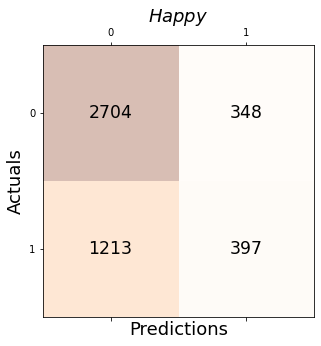

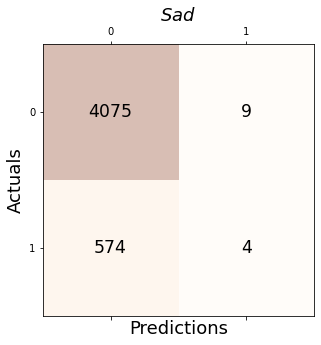

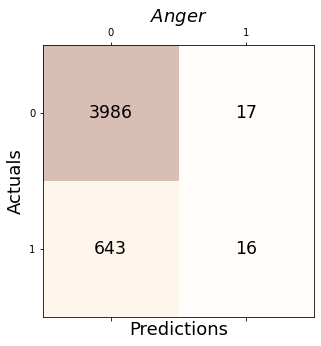

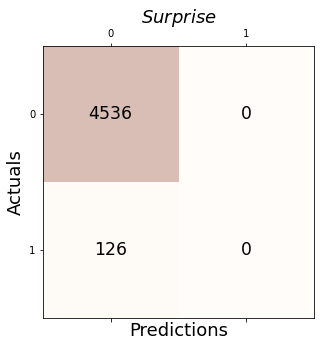

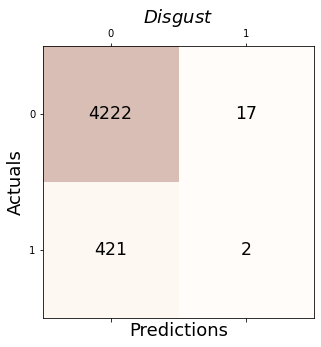

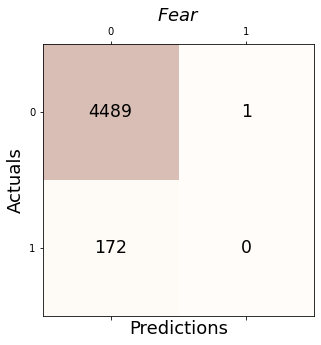

In [228]:
emotion = ['Happy', 'Sad', 'Anger', 'Surprise', 'Disgust', 'Fear']

for n in range(len(emotion)):
    # add a new subplot iteratively
    conf_matrix = confusion_matrix(y_true=y_test_f[n], y_pred=y_hat_f[n])
    #
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    # chart formatting
    ax.set_title('${}$'.format(emotion[n]), fontsize=18)
    ax.set_xlabel('Predictions', fontsize=18)
    ax.set_ylabel('Actuals', fontsize=18) 

In [42]:
def build_model_lstm(hp):  
  model = keras.Sequential([
    keras.layers.LSTM(
        32,
        return_sequences=False,
        activation='relu',
        input_shape = (1, X_train_text.shape[2])
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(
        hp.Choice('final_drop',values=[0.25, 0.5])
    ),
    keras.layers.Dense(6, activation='sigmoid')
    ])
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[9e-4, 1e-4])),
              loss='binary_crossentropy',
              metrics=['BinaryAccuracy'])
  
  return model

In [43]:
tuner_search_lstm=RandomSearch(build_model_lstm,objective=["val_accuracy"],max_trials=10,directory='output_lstm',project_name="MOSEI CNN")

INFO:tensorflow:Reloading Oracle from existing project output_lstm\MOSEI CNN\oracle.json
INFO:tensorflow:Reloading Tuner from output_lstm\MOSEI CNN\tuner0.json


In [44]:
tuner_search_lstm.search(X_train_text, y_train_text,epochs=5)

Trial 10 Complete [00h 00m 08s]
multi_objective: 0.0

Best multi_objective So Far: 0.0
Total elapsed time: 00h 01m 24s
INFO:tensorflow:Oracle triggered exit


In [83]:
model_lstm_hyper=tuner_search_lstm.get_best_models(num_models=1)[0]
model_lstm_hyper.fit(X_train_text, y_train_text, epochs=30, batch_size=10, verbose=1, shuffle=False)

Epoch 1/30
1633/1633 [==============================] - 10s 4ms/step - loss: 0.3451 - binary_accuracy: 0.8710
Epoch 2/30
1633/1633 [==============================] - 7s 4ms/step - loss: 0.3436 - binary_accuracy: 0.8710
Epoch 3/30
1633/1633 [==============================] - 7s 4ms/step - loss: 0.3427 - binary_accuracy: 0.8710
Epoch 4/30
1633/1633 [==============================] - 7s 4ms/step - loss: 0.3426 - binary_accuracy: 0.8710
Epoch 5/30
1633/1633 [==============================] - 7s 5ms/step - loss: 0.3421 - binary_accuracy: 0.8710
Epoch 6/30
1633/1633 [==============================] - 8s 5ms/step - loss: 0.3417 - binary_accuracy: 0.8710
Epoch 7/30
1633/1633 [==============================] - 7s 4ms/step - loss: 0.3411 - binary_accuracy: 0.8710
Epoch 8/30
1633/1633 [==============================] - 8s 5ms/step - loss: 0.3409 - binary_accuracy: 0.8710
Epoch 9/30
1633/1633 [==============================] - 7s 4ms/step - loss: 0.3408 - binary_accuracy: 0.8710
Epoch 10/30
1633/1

In [47]:
yhat_lstm = model_lstm_hyper.predict(X_test_text)

In [51]:
yhat_lstm[1]

array([0.36505556, 0.12270793, 0.11696479, 0.02556542, 0.07726943,
       0.02738133], dtype=float32)

In [54]:
yhat[1]

array([0.3216885 , 0.14271232, 0.3334688 , 0.04644832, 0.28505594,
       0.02101082], dtype=float32)

In [66]:
y_test_text[1]

array([0, 0, 1, 0, 0, 0])

In [64]:
y_test[0]

array([0, 0, 0, 0, 0, 0])